In [1]:
%load_ext jupyternotify
from pytket import Circuit, Qubit, Bit, OpType
from pytket.utils.operators import QubitPauliOperator
from sympy import symbols
from openfermion import QubitOperator
from random import sample
import numpy as np
from pytket.backends.ibm import AerStateBackend, AerBackend, AerUnitaryBackend, IBMQBackend
from scipy.linalg import expm, sinm, cosm
from sympy.physics.quantum.dagger import Dagger
import functools
import operator
import itertools    
from openfermion import get_sparse_operator
from scipy.optimize import minimize, LinearConstraint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

backend = AerStateBackend()

def fidelity(rsv, gsv): 
    
    #rsv = real state vector 
    #gsv = generated statev vector 
    
    rsv_conj = np.conj(rsv)
    fid = sum(rsv_conj*gsv) * np.conj(sum(rsv_conj*gsv))
    
    return fid

#constants 
lamb = np.float(2)
s = np.exp(-1 / (2 * lamb)) - 1
cst1 = (s / 2 + 1) ** 2
cst2 = (s / 2) * (s / 2 + 1)
cst3 = (s / 2) ** 2

<IPython.core.display.Javascript object>

In [2]:
def real(n, weights): #n is the number of qubits 
    
    real_circ = Circuit()
    qubits = real_circ.add_q_register('q', n)

    for i in range(n) :
        real_circ.Rx(weights[i] , qubits[i])
        
    for i in range(n) :
        real_circ.Ry(weights[n+i], qubits[i])
        
    for i in range(n) :
        real_circ.Rz(weights[(2*n) + i], qubits[i])
        
    for i in range(n-1) :
        real_circ.CX(qubits[i], qubits[i+1])
        
    for i in range(n-1) :
        real_circ.add_gate(OpType.XXPhase, weights[(n*3)+i], [qubits[i], qubits[i+1]])     

    for i in range(n-1) :
        real_circ.add_gate(OpType.YYPhase, weights[(n*3)+i+1*(n-1)], [qubits[i], qubits[i+1]])     
        
    for i in range(n-1) :
        real_circ.add_gate(OpType.ZZPhase, weights[(n*3)+i+2*(n-1)], [qubits[i], qubits[i+1]])     
        

    backend.compile_circuit(real_circ)
    state_handle = backend.process_circuit(real_circ)
    statevector = backend.get_state(state_handle)
    
    return real_circ, statevector


In [3]:
def generator(n, weights):
    
    gen_circ = Circuit()
    qubits = gen_circ.add_q_register('q', n)

    for i in range(n) :
        gen_circ.Rx(weights[i] , qubits[i])
        
    for i in range(n) :
        gen_circ.Ry(weights[n+i], qubits[i])
        
    for i in range(n) :
        gen_circ.Rz(weights[(2*n) + i], qubits[i])
        
    for i in range(n-1) :
        gen_circ.CX(qubits[i], qubits[i+1])
        
    for i in range(n-1) :
        gen_circ.add_gate(OpType.XXPhase, weights[(n*3)+i], [qubits[i], qubits[i+1]])     

    for i in range(n-1) :
        gen_circ.add_gate(OpType.YYPhase, weights[(n*3)+i+1*(n-1)], [qubits[i], qubits[i+1]])     
        
    for i in range(n-1) :
        gen_circ.add_gate(OpType.ZZPhase, weights[(n*3)+i+2*(n-1)], [qubits[i], qubits[i+1]])     
        

    backend.compile_circuit(gen_circ)
    state_handle = backend.process_circuit(gen_circ)
    statevector = backend.get_state(state_handle)
    
    return gen_circ, statevector


In [4]:
def discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv):
    
    #creates the hermitian operators phi and psi 
    disc_weights_phi = disc_weights[:len(disc_weights)//2]
    disc_weights_psi = disc_weights[len(disc_weights)//2:]

    tuple_list_phi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_phi, itertools.product(['X', 'Y', 'Z'], range(n)))]
    tuple_list_psi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_psi, itertools.product(['X', 'Y', 'Z'], range(n)))]

    measurements_phi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_phi))
    measurements_psi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_psi))

    iden_phi =  functools.reduce(operator.add, ( (disc_weights_phi[len(disc_weights_phi)-1] ) * QubitOperator(" ") ))
    iden_psi =  functools.reduce(operator.add, ( (disc_weights_psi[len(disc_weights_psi)-1]) * QubitOperator(" ") ))

    phi = operator.add(iden_phi, measurements_phi)
    psi = operator.add(iden_psi, measurements_psi)

    #convert phi and psi operators to matrix 
    psi_matrix = get_sparse_operator(psi).todense()
    phi_matrix = get_sparse_operator(phi).todense()
    
    #calculate expectation values 
    psi_exp = backend.get_operator_expectation_value(real_circ, QubitPauliOperator.from_OpenFermion(psi))
    phi_exp = backend.get_operator_expectation_value(gen_circ, QubitPauliOperator.from_OpenFermion(phi)) 

    #calculate values for A and B which go into the calculation for the regterm
    A = expm(np.float(-1 / lamb) * phi_matrix)
    B = expm(np.float(1 / lamb) * psi_matrix)

    term1 = np.matmul(Dagger(gen_sv) , np.matmul(A, gen_sv))
    term2 = np.matmul(Dagger(real_sv), np.matmul(B,real_sv))
    term3 = np.matmul(Dagger(gen_sv), np.matmul(B,real_sv))
    term4 = np.matmul(Dagger(real_sv), np.matmul(A,gen_sv))
    term5 = np.matmul(Dagger(gen_sv), np.matmul(A,real_sv))
    term6 = np.matmul(Dagger(real_sv), np.matmul(B,gen_sv))
    term7 = np.matmul(Dagger(gen_sv), np.matmul(B,gen_sv))
    term8 = np.matmul(Dagger(real_sv), np.matmul(A,real_sv))

    regterm = (lamb / np.e * (cst1 * term1 * term2 - cst2 * term3 * term4 - cst2 * term5 * term6 + cst3 * term7 * term8)).item()

    return psi_exp , phi_exp , regterm



In [5]:
def disc_loss(disc_weights):
    
    psi_exp , phi_exp , regterm = discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv)
    loss = np.real(psi_exp - phi_exp - regterm) 
    
    return -loss 

    
def gen_loss(gen_weights):
    
    gen_circ, gen_sv = generator(n, gen_weights)
    
    psi_exp , phi_exp , regterm = discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv)
    loss = np.real(psi_exp - phi_exp - regterm)

    return loss

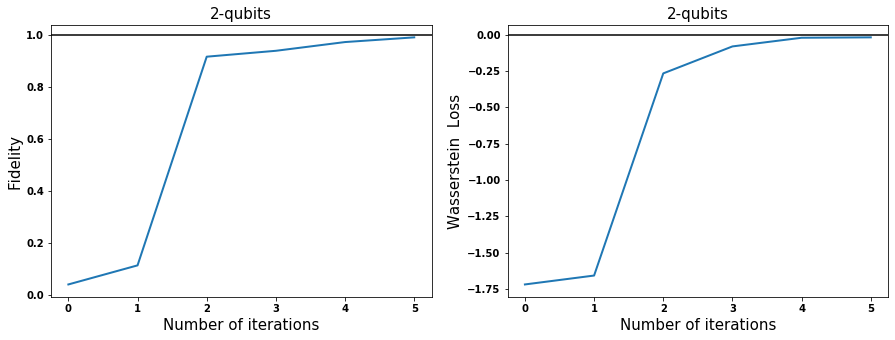

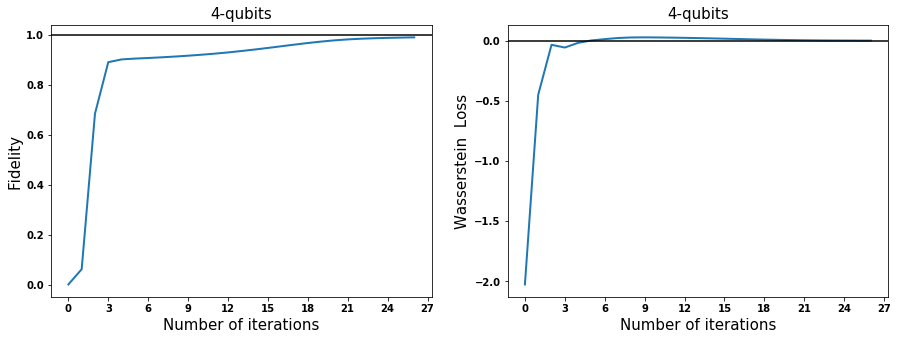

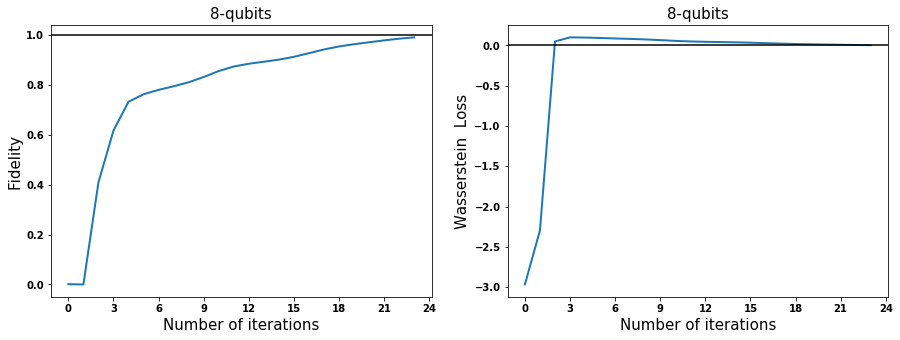

<IPython.core.display.Javascript object>

CPU times: user 14h 5min 29s, sys: 12h 9min 36s, total: 1d 2h 15min 5s
Wall time: 3h 45min 49s


In [6]:
%%time
%%notify

for n in [2,4,8]:

    real_weights = np.random.uniform(0,2, (6*n) - 3) 
    init_gen_weights = np.random.uniform(0,2, (6*n) - 3) 
    init_disc_weights = np.random.uniform(0,1, (6*n)+2)

    gen_weights = init_gen_weights
    disc_weights = init_disc_weights

    bounds = (0, 2)
    bounds_gen_weights=[]
    for i in range(len(gen_weights)):
        bounds_gen_weights.append(bounds)

    bounds = (0, 2)
    bounds_disc_weights=[]
    for i in range(len(disc_weights)):
        bounds_disc_weights.append(bounds)

    real_circ, real_sv = real(n, real_weights)
    gen_circ, gen_sv = generator(n, gen_weights)
    fid = fidelity(real_sv, gen_sv)

    gloss = []
    f= []
    f.append(fid)
    gloss.append(gen_loss(gen_weights))

    niter = 0 #number of while loop iterations
    while fid < 0.99:

        #maximise loss for disc
        disc_result = minimize(disc_loss, disc_weights, method='Powell', bounds = bounds_disc_weights, options={ 'maxiter': 2000, 'maxfev':n*3,  'ftol':1e-10, 'xtol': 1e-3})
        disc_weights = disc_result.x

        #minimise loss for gen 
        gen_result = minimize(gen_loss, gen_weights, method='Powell', bounds = bounds_gen_weights, options={ 'maxiter': 2000, 'maxfev':n*3,  'ftol':1e-10, 'xtol': 1e-3})
        gen_weights = gen_result.x

        #calculate the updated gen circ and statevector 
        gen_circ, gen_sv = generator(n, gen_weights)

        fid = fidelity(real_sv, gen_sv)
        f.append(fid)
        gloss.append(gen_loss(gen_weights))

        niter += 1

        if niter == 30:
            break 


    #plot the figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    y = np.real(f)
    x =list(range(0, len(y)))

    y2 = gloss
    x2 =list(range(0, len(y2)))


    ax1.plot(x,y , linewidth=2)
    ax1.axhline(y=1, color='k', linestyle='-')

    ax2.plot(x2, y2 , linewidth=2)
    ax2.axhline(y=0, color='k', linestyle='-')

    ax1.set_title(str(n)+'-qubits', fontsize = 15)
    ax2.set_title(str(n)+'-qubits', fontsize = 15)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
        tick.label1.set_fontweight('bold')
    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
        tick.label1.set_fontweight('bold')

    for tick in ax2.xaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
        tick.label1.set_fontweight('bold')
    for tick in ax2.yaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
        tick.label1.set_fontweight('bold')

    for axis in [ax1.xaxis, ax2.xaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))


    ax1.set_xlabel('Number of iterations', fontsize = 15)
    ax1.set_ylabel('Fidelity', fontsize = 15)

    ax2.set_xlabel('Number of iterations', fontsize = 15)
    ax2.set_ylabel('Wasserstein  Loss', fontsize = 15)

    fig.savefig(str(n)+'qubit.png')
